# **CONTROL MODEL FOR VEHICLE LATERAL DYNAMICS**

### Import packages

In [1]:
# Import necessary packages
import sys, os
import pandas as pd

# import nnodely modules
from nnodely import *
from nnodely.support.utils import *
from nnodely.support import earlystopping
from nnodely.support.earlystopping import select_best_model

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


### Configurations

In [2]:

path_folder = os.path.join('trained_models')    # folder to save the model
lat_dyna_control = nnodely(visualizer=MPLNotebookVisualizer(),seed=1,workspace=path_folder,save_history=False)

# Neural Network model

### Import NN vehicle model

In [3]:
lat_dyna_control.loadModel('vehicle_model')
lat_dyna_control.neuralizeModel()

=============================== Load JSON Model ================================
Model loaded from:            trained_models/vehicle_model.json
[neuralizeModel] Closed loop on Mul77_int33 with sample in the future.
[neuralizeModel] Closed loop on Mul87_int34 with sample in the future.
================================ nnodely Model =================================
{'Constants': {'SampleTime': {'dim': 1, 'values': 0.05},
               'W_fir': {'dim': 1,
                         'sw': 30,
                         'values': [[0.023806948214769363],
                                    [0.03067079372704029],
                                    [0.039163894951343536],
                                    [0.04956628382205963],
                                    [0.062176525592803955],
                                    [0.07730474323034286],
                                    [0.09526325762271881],
                                    [0.116354800760746],
                                

### Model definition

In [4]:
# ----------------------------------------------------------------
# Inputs
# ----------------------------------------------------------------
curv_in  = Input('controller_curv_in')          # [1/m] path curvature
vx_in    = Input('controller_vx_in')            # [m/s] longitudinal velocity
steer_in = Input('controller_steer_in')         # [rad] steering wheel angle
ax_in    = Input('controller_ax_in')            # [m/s^2] longitudinal acceleration

# ----------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------
samples_past_steer = 30  # number of samples in the past for the steering wheel angle prediction
samples_prediction = 30  # number of samples for future manoeuvre
n_channels_vx = 8        # number of channels for activation function vx
chan_vx =  list(np.linspace(8, 23, num=n_channels_vx)) # centers of the channels vx
chan_ax = [-2,-1,0.0,1.0,2.0]   # centers of the channels ax

# Exponential weights for normalisation of FIR parameters during training
W_prev = np.flip(np.array([[np.exp(-(i/(samples_prediction/2))**2)] for i in range(-samples_prediction+1,1)]))
W_past = np.array([[np.exp(-(i/(samples_past_steer/2))**2)] for i in range(-samples_past_steer+2,1)])

W_fir_init = Constant('W_fir_init', sw = (samples_past_steer-1), values=W_past)
W_fir_target = Constant('W_fir_target', sw =samples_prediction, values=W_prev)

# ----------------------------------------------------------------
# Understeer correction function
# ----------------------------------------------------------------
def understeer_corr_local_control(vx,curv,  # inputs
                                  A,        # constant
                                  ):
    return curv * (1 + A * torch.pow(vx, 2))

understeer_corr = ParamFun(understeer_corr_local_control)

# ----------------------------------------------------------------
# Local models
# ----------------------------------------------------------------
# Activation functions
activ_fnc_ax = Fuzzify(centers=chan_ax, functions='Triangular')(ax_in.last())
activ_fnc_vx = Fuzzify(centers=chan_vx, functions='Triangular')(vx_in.last())

# Understeer coefficient: the value of the constant is taken by the model and is function of the acceleration ax
A = Constant('A',values=[lat_dyna_control.parameters['A_0'][0][0],lat_dyna_control.parameters['A_1'][0][0],lat_dyna_control.parameters['A_2'][0][0],lat_dyna_control.parameters['A_3'][0][0],lat_dyna_control.parameters['A_4'][0][0]])
A_ax = Sum( activ_fnc_ax * A )      # Constant A function of ax

# FIR target trajectory
local_model_target = LocalModel(pass_indexes=True,
                          input_function=lambda idx: Fir(output_dimension=1,W_init = 'init_constant',W_init_params={"value": 0.01}, W=f'Fir_target_{idx[0]}'))
# FIR initial condition
delta_ic     = Fir(output_dimension=1, W="Fir_InitCondition", W_init="init_constant", W_init_params={"value": 0.01})(steer_in.sw([-samples_past_steer,-1])*W_fir_init)

# Understeer correction
out = understeer_corr( vx_in.sw([-1,(samples_prediction-1)]),curv_in.sw([-1,(samples_prediction-1)]), A_ax )

# Local model
delta_target = local_model_target(out*W_fir_target , activ_fnc_vx)

# NN output
delta        = delta_target + delta_ic

# ----------------------------------------------------------------
# Outputs
# ----------------------------------------------------------------
steer_from_target  = Output('controller_steer_from_target',delta_target)
steer_from_ic      = Output('controller_steer_from_ic',delta_ic)
steer_control      = Output('controller_steer_out',delta)

# ----------------------------------------------------------------
# Add controller model and connect to the vehicle model
# ----------------------------------------------------------------
lat_dyna_control.addModel('control_steer',[steer_from_target,steer_from_ic,steer_control])
lat_dyna_control.addClosedLoop(steer_control,steer_in)
lat_dyna_control.addConnect(steer_control,'model_steer_in')

### Loss functions definitions

The loss functions are the same used for the training of the vehicle model: mse error on curvature value and mse value on heading value.

### Model neuralization

In [5]:
# Generate the model
lat_dyna_control.neuralizeModel(sample_time=0.05)  # neuralize the model with the chosen sample time

[neuralizeModel] Closed loop on Mul77_int33 with sample in the future.
[neuralizeModel] Closed loop on Mul87_int34 with sample in the future.
[neuralizeModel] Connect on model_steer_in with sample in the future.
================================ nnodely Model =================================
{'Constants': {'A': {'dim': 5,
                     'values': [0.12241744995117188,
                                0.13215704262256622,
                                0.13487723469734192,
                                0.13838686048984528,
                                0.14319394528865814]},
               'SampleTime': {'dim': 1, 'values': 0.05},
               'W_fir': {'dim': 1,
                         'sw': 30,
                         'values': [[0.023806948214769363],
                                    [0.03067079372704029],
                                    [0.039163894951343536],
                                    [0.04956628382205963],
                                    [0.06217

# Training

### Dataset Load

In [6]:
lat_dyna_control.loadData('test_set', source='dataset/test',
                        format=['', ('controller_ax_in','model_ax_in'),'', ('controller_vx_in','model_vx_in'), ('model_curv_in','controller_curv_in'), ('model_steer_in','controller_steer_in')], skiplines=1)

lat_dyna_control.loadData('training_set', source='dataset/training',
                        format=['', ('model_ax_in','controller_ax_in'), '', ('controller_vx_in','model_vx_in'), ('model_curv_in','controller_curv_in'), 'model_steer_in', ''],
                        skiplines=1)
lat_dyna_control.loadData('validation_set', source='dataset/validation',
                        format=['', ('model_ax_in','controller_ax_in'), '', ('controller_vx_in','model_vx_in'), ('model_curv_in','controller_curv_in'), 'model_steer_in', ''],
                        skiplines=1)

============================ nnodely Model Dataset =============================
Dataset Name:                 test_set
Number of files:              1
Total number of samples:      1047
Shape of controller_steer_in: (1047, 29, 1)
Shape of controller_vx_in:    (1047, 30, 1)
Shape of controller_ax_in:    (1047, 1, 1)
Shape of controller_curv_in:  (1047, 30, 1)
Shape of model_ax_in:         (1047, 1, 1)
Shape of model_curv_in:       (1047, 1, 1)
Shape of model_steer_in:      (1047, 30, 1)
Shape of model_vx_in:         (1047, 2, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 training_set
Number of files:              4
Total number of samples:      12100
Shape of controller_vx_in:    (12100, 30, 1)
Shape of controller_ax_in:    (12100, 1, 1)
Shape of controller_curv_in:  (12100, 30, 1)
Shape of model_ax_in:         (12100, 1, 1)
Shape of model_curv_in:       (12100, 1, 1)
Shape of model_steer_in:      (12100, 30, 1)
Shape 

### Training

In [7]:
# Default training parameters definition
training_pars = {'num_of_epochs': 5,
                 'val_batch_size': 64,
                 'train_batch_size': 16,
                 'lr': 1e-3,
                 'train_dataset': 'training_set',
                 'validation_dataset': 'validation_set',
                 'models': 'control_steer',
                 'optimizer': 'Adam',
                 'shuffle_data': True,
                 'select_model': select_best_model,
                 'early_stopping': earlystopping.early_stop_patience,
                 'early_stopping_params': {'patience': 3, 'error': 'heading_error'}}

======================== nnodely Model Train Parameters ========================
models:                       ['control_steer']
num of epochs:                5
update per epochs:            755
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'heading_error', 'patience': 3}
prediction samples:           5
step:                         0
closed loop:                  {}
connect:                      {}
train dataset:                training_set
	- batch size:                16
	- num of samples:            12100
	- num of first samples:      12080
validation dataset:           validation_set
	- batch size:                64
	- num of samples:            5560
	- num of first samples:      5550
minimizers:                   {'curv_error': {'A': 'SamplePart95',
                                              'B': 'Mul72',
                                              'loss': '

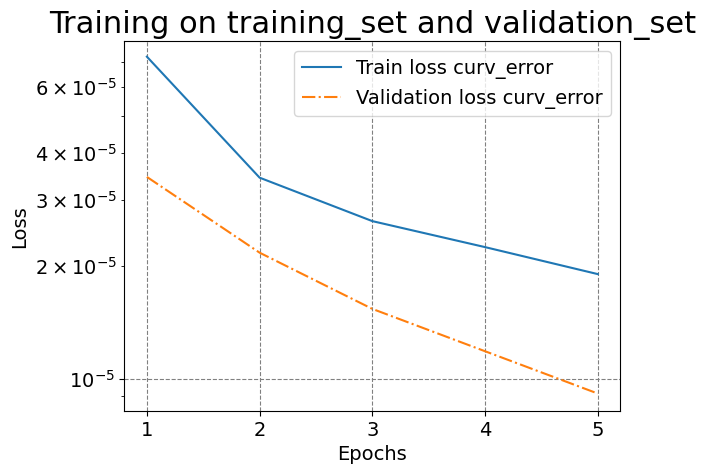

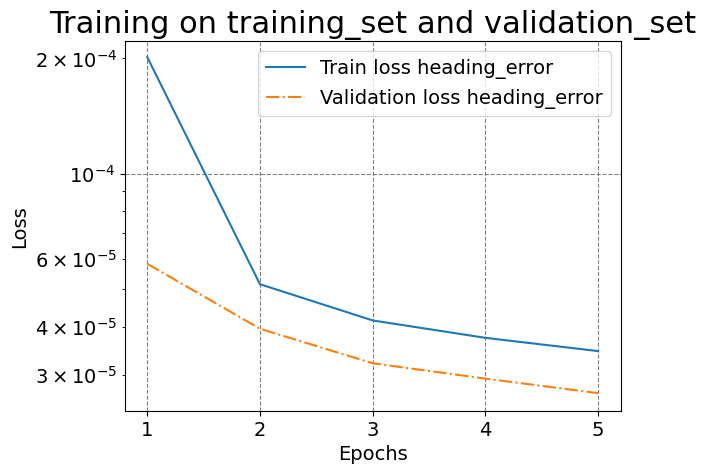

Selected the model at the epoch 5.


In [8]:
# First training without few samples in the future
lat_dyna_control.trainModel(training_params=training_pars,
                            prediction_samples=5)

======================== nnodely Model Train Parameters ========================
models:                       ['control_steer']
num of epochs:                10
update per epochs:            453
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'heading_error', 'patience': 3}
prediction samples:           80
step:                         10
closed loop:                  {}
connect:                      {}
train dataset:                training_set
	- batch size:                16
	- num of samples:            12100
	- num of first samples:      11780
validation dataset:           validation_set
	- batch size:                64
	- num of samples:            5560
	- num of first samples:      5400
minimizers:                   {'curv_error': {'A': 'SamplePart95',
                                              'B': 'Mul72',
                                              'loss'

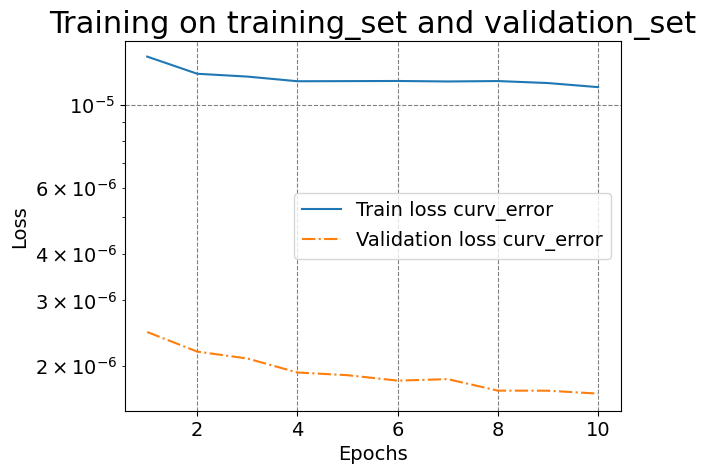

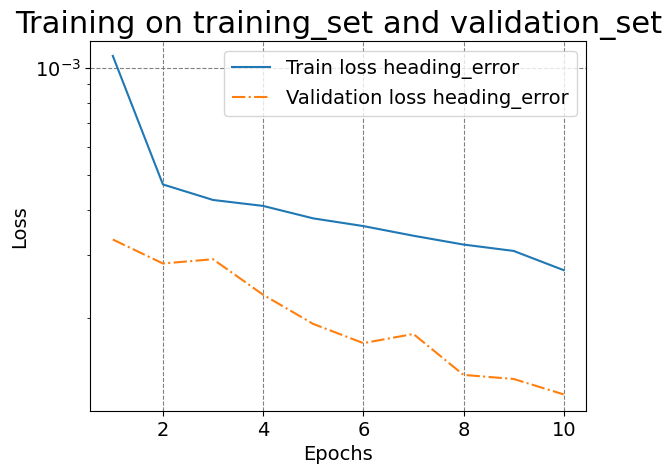

Selected the model at the epoch 10.


In [9]:
# Training with integral error 4s in the future
lat_dyna_control.trainModel(training_params=training_pars,
                            num_of_epochs=10,
                            prediction_samples=80,   # 4s in the future
                            step=10)

# Plots

### FIR filters weights

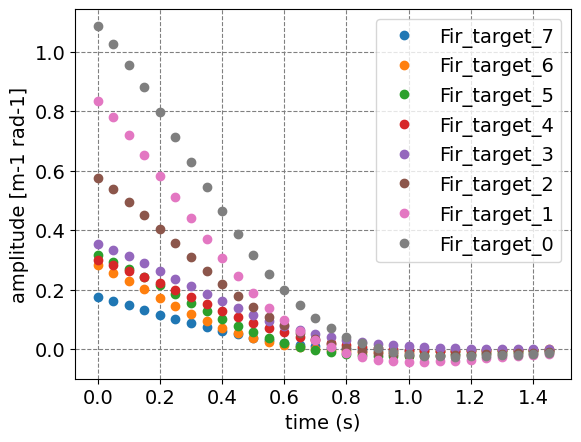

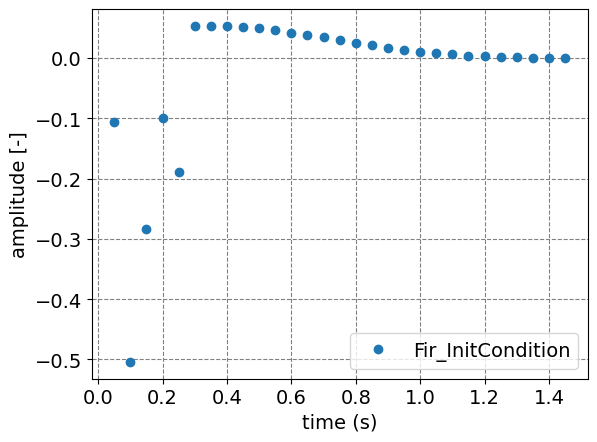

In [10]:
params_fir_target = {}
params_fir_ic = {}
sampling_time = 0.05

# Plot
plt.figure()

for key, value in lat_dyna_control.parameters.items():
    if key.startswith('Fir_target'):
        params_fir_target[key] = lat_dyna_control.parameters[key]

    if key.startswith('Fir_InitCondition'):
        params_fir_ic[key] = lat_dyna_control.parameters[key]

for key, value in params_fir_target.items():
    vals = np.array(value).flatten()
    t = np.arange(0, sampling_time * len(vals), sampling_time)
    plt.plot(t,vals * W_prev.flatten(), 'o', label=key)

plt.xlabel('time (s)')
plt.ylabel('amplitude [m-1 rad-1]')
plt.legend()
plt.grid(True)
plt.show(block=False)

plt.figure()
for key, value in params_fir_ic.items():
    vals = np.array(value).flatten()
    t = np.arange(sampling_time, sampling_time * (len(vals)+1), sampling_time)
    plt.plot(t,np.flip(vals * W_past.flatten()),'o',label=key)
plt.xlabel('time (s)')
plt.ylabel('amplitude [-]')
plt.legend()
plt.grid(True)
plt.show(block=False)

### Analyze model

================== nnodely Model Results for training_set =================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     1.140e-06     |     4.404e-03     |     2.391e+06     |
|heading_error|     5.398e-04     |     5.965e-04     |     2.393e+06     |
|-------------------------------------------------------------------------|
|    Total    |     2.705e-04     |     2.500e-03     |     2.392e+06     |
|-------------------------------------------------------------------------|


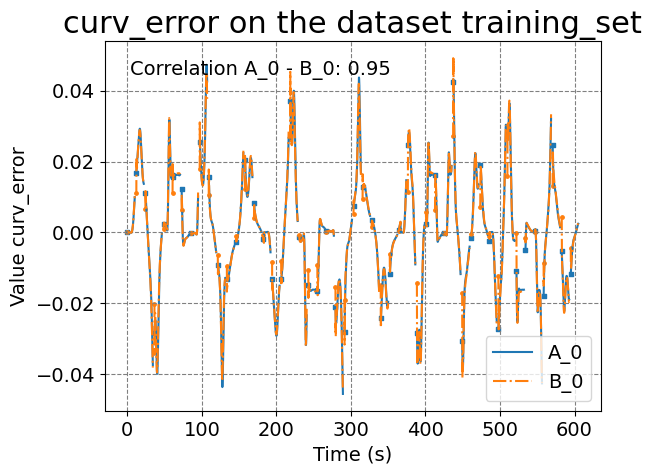

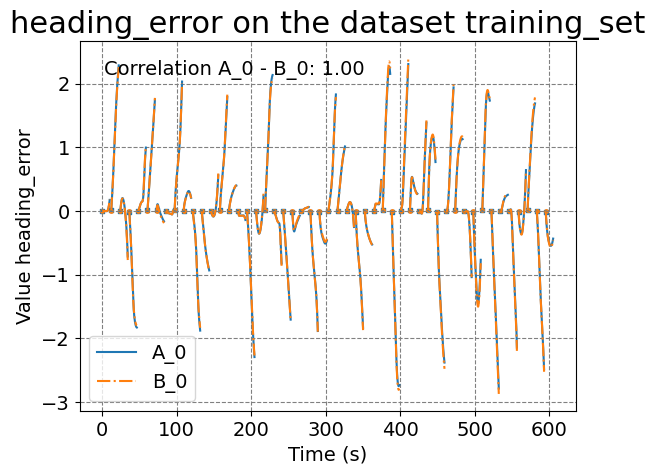

================= nnodely Model Results for validation_set ================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     9.094e-07     |     3.294e-03     |     1.076e+06     |
|heading_error|     6.473e-04     |     6.261e-04     |     1.078e+06     |
|-------------------------------------------------------------------------|
|    Total    |     3.241e-04     |      1.96e-03     |     1.077e+06     |
|-------------------------------------------------------------------------|


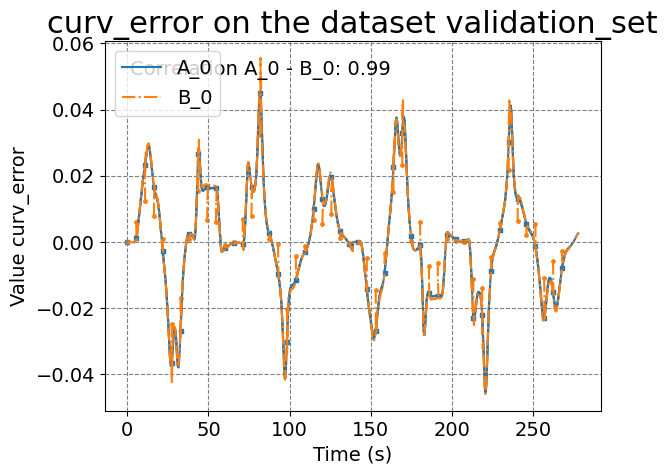

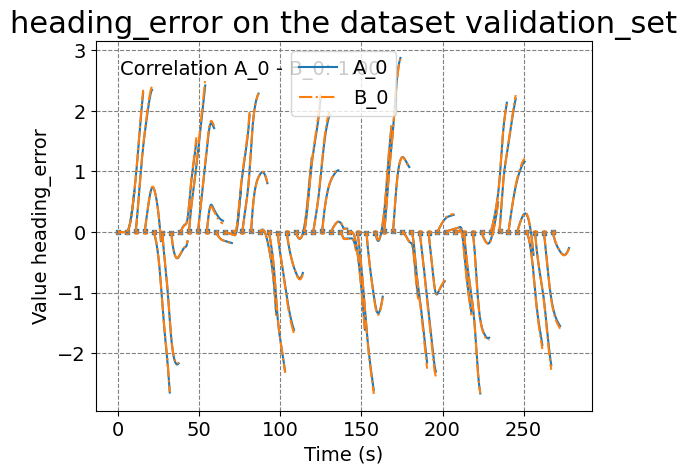

==================== nnodely Model Results for test_set ===================
|     Loss    |        mse        |        FVU        |        AIC        |
|             |    small better   |    small better   |    lower better   |
|-------------------------------------------------------------------------|
|  curv_error |     4.818e-07     |     1.589e-03     |     2.147e+05     |
|heading_error|     9.289e-04     |     8.999e-04     |     2.664e+05     |
|-------------------------------------------------------------------------|
|    Total    |     4.647e-04     |     1.245e-03     |     2.405e+05     |
|-------------------------------------------------------------------------|


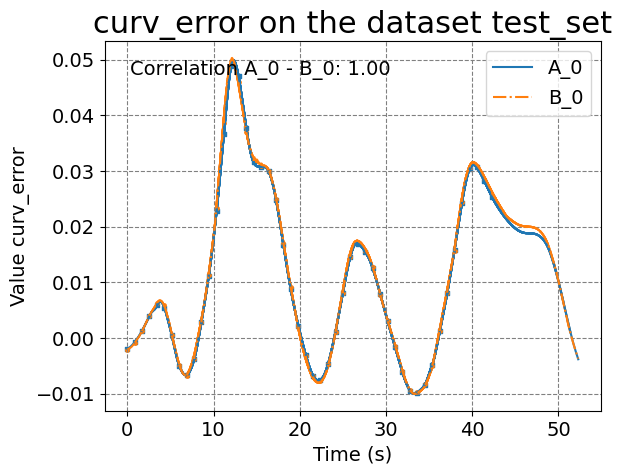

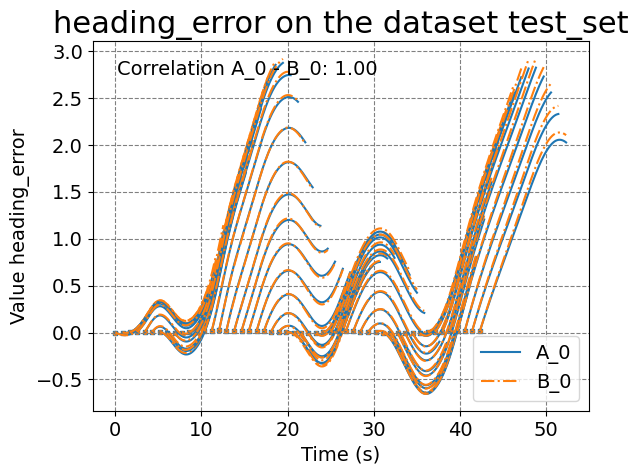

In [11]:
lat_dyna_control.analyzeModel('training_set',prediction_samples=200)       # 10s prediction
lat_dyna_control.analyzeModel('validation_set',prediction_samples=200)
lat_dyna_control.analyzeModel('test_set',prediction_samples=200)

### Plot: curvature comparison

[__call__] Different number of samples between inputs [MAX 1105 = 1105; MIN 1076 = 1076]


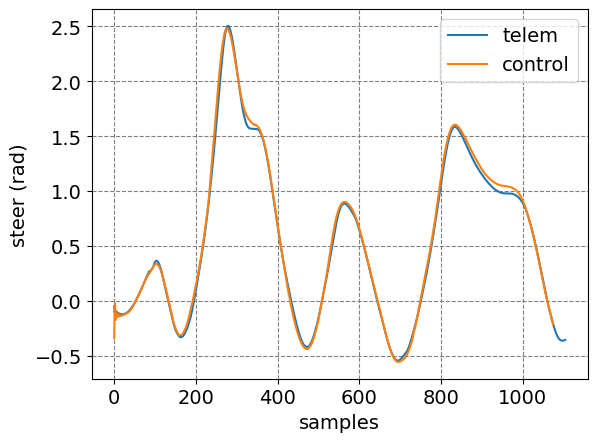

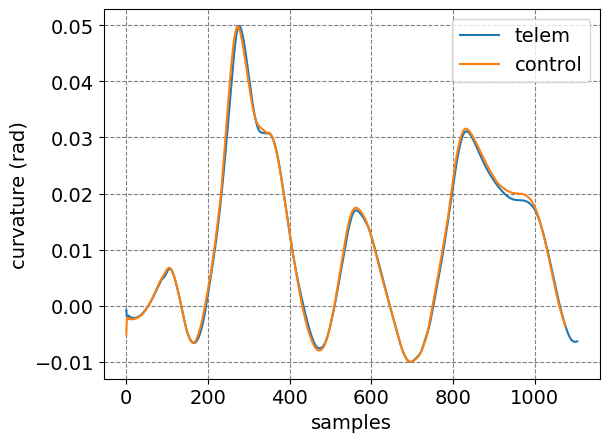

In [17]:
data = pd.read_csv("dataset/test/test_set.csv")

sample_test_set = {
    'controller_vx_in' : np.array(data['vx']),
    'model_vx_in' : np.array(data['vx']),
    'controller_curv_in' : np.array(data['curv']),
    'model_curv_in' : np.array(data['curv']),
    'controller_steer_in' : np.array(data['steer']),
    'model_steer_in': np.array(data['steer']),
    'model_ax_in' : np.array(data['ax']),
    'controller_ax_in': np.array(data['ax'])
}

out_nn_test_set  = lat_dyna_control(sample_test_set, sampled=False, prediction_samples=1100)

# plot the results
plt.figure()
plt.plot(data['steer'],label='telem')
plt.plot(out_nn_test_set['controller_steer_out'],label='control')
plt.xlabel('samples')
plt.ylabel('steer (rad)')
plt.legend()
plt.grid()

plt.figure()
plt.plot(data['curv'],label='telem')
plt.plot(out_nn_test_set['model_curv'],label='control')
plt.xlabel('samples')
plt.ylabel('curvature (rad)')
plt.legend()
plt.grid()

# Export ONNX

In [18]:
# Save json model
lat_dyna_control.saveModel('control_model')

# Remove Minimize
lat_dyna_control.removeMinimize(['heading_error','curv_error'])
lat_dyna_control.neuralizeModel()

# Export ONNX
lat_dyna_control.exportONNX(['controller_curv_in', 'controller_vx_in','controller_ax_in','controller_steer_in'],['controller_steer_out','controller_steer_from_ic','controller_steer_from_target'],'controller',models='control_steer')


=============================== Save JSON Model ================================
Model saved in:               trained_models/control_model.json
[neuralizeModel] Connect on model_steer_in with sample in the future.
================================ nnodely Model =================================
{'Constants': {'A': {'dim': 5,
                     'values': [0.12241744995117188,
                                0.13215704262256622,
                                0.13487723469734192,
                                0.13838686048984528,
                                0.14319394528865814]},
               'W_fir': {'dim': 1,
                         'sw': 30,
                         'values': [[0.023806948214769363],
                                    [0.03067079372704029],
                                    [0.039163894951343536],
                                    [0.04956628382205963],
                                    [0.062176525592803955],
                                    [0